In [5]:
import corner
import matplotlib.pyplot as plt
import numpy as np
import yaml
import h5py
import sys
import matplotlib

sys.path.append("../lib/")
import matplotlib.pyplot as plt
from figparams import *

plt.rcParams.update(rc_params)
from utils import *
import scipy.interpolate as interp
import average_envelope as env
import modulation as mod

# interpolate ev_gamma to have smooth curve
from scipy.interpolate import interp1d


In [6]:
def corn(
    result,
    color,
    label=None,
    true=None,
    fig=None,
    alpha=1,
    line_s="-",
    ht="step",
    linewidth=2,
    bg_color="white",
    subplot_bg=None,
):
    if not fig:
        fig = plt.figure(figsize=(8, 8))
        fig.patch.set_facecolor(bg_color)

    # Enable filled contours and set their color to match subplot background
    fill_color = subplot_bg if subplot_bg else bg_color

    corner.corner(
        result,
        labels=label,
        fig=fig,
        color=color,
        alpha=alpha,
        labelpad=0.1,
        levels=[0.9],
        hist_kwargs={
            "density": True,
            "histtype": ht,
            "linestyle": line_s,
            "alpha": alpha,
        },
        plot_datapoints=False,
        plot_contours=True,
        plot_density=False,
        fill_contours=True,  # Enable filled contours
        label_kwargs={"fontsize": 13},
        ticklabel_kwargs={"fontsize": 12},
        contours_kwargs={"linewidths": 1},
        contourf_kwargs={"colors": [fill_color]},  # Fill with background color
        smooth=True,
    )

    ndim = result.shape[1]
    axes = np.array(fig.axes).reshape((ndim, ndim))

    # Set subplot backgrounds if specified
    if subplot_bg:
        for i in range(ndim):
            for j in range(ndim):
                if i >= j:
                    axes[i, j].set_facecolor(subplot_bg)

    # Loop over the diagonal
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(true[i], color="k", linewidth=1, linestyle="--")

    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(true[xi], color="k", linewidth=1, linestyle="--")
            ax.axhline(true[yi], color="k", linewidth=1, linestyle="--")

    return fig

In [7]:
colors_tot = get_colormap_colors(26, "plasma")
colors = colors_tot[:12][::-1]

In [8]:
samples_nested_all = []
mode = "cyclo"
for i in range(26):
    with h5py.File(
        f"../data/first_year_differential_oneweek/pack_{i + 1}/nested/Gamma/{mode}/result.hdf5",
        "r",
    ) as f:
        # Example: access a dataset
        posterior = f["posterior_samples"][:]

    source = f"../data/first_year_differential_oneweek/pack_{i + 1}/nested/Gamma/{mode}/pe_pack{i + 1}_{mode}.yaml"
    # extract true of source
    # Read the YAML file

    with open(source, "r") as file:
        sources = yaml.safe_load(file)["sources"]

    true = [item["injected"] for category in sources.values() for item in category]

    # Get the dtype and field names
    dtype = posterior.dtype

    label = dtype.names[: len(true)]  # first 7 parameter names

    # Stack values into a 2D array (n_samples, n_params)
    samples = np.vstack([posterior[name] for name in label]).T
    # subtract the true values
    true_as_samples = np.array(true)
    # Reshape the true values to match the shape of samples
    true_as_samples = np.tile(true_as_samples, (samples.shape[0], 1))
    samples_nested = samples - true_as_samples
    samples_nested_all.append(samples)

In [9]:
t1, t2 = [], []
for i in range(1, 27):
    ts, te = np.loadtxt(
        f"../data/first_year_differential_oneweek/pack_{i}/time_interval.txt"
    )
    t1.append(ts)
    t2.append(te)
t1 = np.array(t1).flatten()
t2 = np.array(t2).flatten()

In [10]:
bf, ev_C, ev_S, bf_err = [], [], [], []

for i in range(26):
    with h5py.File(
        f"../data/first_year_differential_oneweek/pack_{i + 1}/nested/Gamma/cyclo/result.hdf5",
        "r",
    ) as f:
        ev_cyclo = f["log_evidence"][()]
        err_cyclo = f["log_evidence_error"][()]

    with h5py.File(
        f"../data/first_year_differential_oneweek/pack_{i + 1}/nested/Gamma/stat/result.hdf5",
        "r",
    ) as f:
        ev_stat = f["log_evidence"][()]
        err_stat = f["log_evidence_error"][()]

    ev_C.append(ev_cyclo)
    ev_S.append(ev_stat)
    bf.append(ev_cyclo - ev_stat)
    bf_err.append(np.sqrt(err_cyclo**2 + err_stat**2))
    # sum in quadrature


ev_S = np.array(ev_S)
ev_C = np.array(ev_C)
bf = np.array(bf)
bf_err = np.array(bf_err)


x = t1[1::2] / (86400 * 7)
fun = interp1d(x, ev_C - np.mean(ev_C), kind="cubic")
xnew = np.linspace(x[0], x[-1], 1000)
ev_gamma_smooth = fun(xnew)


year = 31557600.0
t = np.linspace(x[0] - 2, x[-1] + 2, 1000)
A, _ = mod.envelopes_gaussian(
    EclipticLatitude=true[5],
    EclipticLongitude=true[6],
    Psi=true[7],
    Sigma1=true[8],
    Sigma2=true[9],
    LISA_Orbital_Freq=1 / year,
    t=t * 86400 * 7,
)


# compute second derivative
A_1 = np.gradient(A**2, xnew * 86400 * 7)
A_2 = np.gradient(A_1, xnew * 86400 * 7)

tweek = t

In [11]:
label_plot = [
    r"$\Delta\alpha $",
    r"$\Delta{\mathcal{A}}$",
    r"$\Delta{\log_{10}\left(\frac{f_{\mathrm{knee}}}{\rm Hz}\right)}$",
    r"$\Delta{\log_{10}\left(\frac{f_{1}}{\rm Hz}\right)}$",
    r"$\Delta{\log_{10}\left(\frac{f_{2}}{\rm Hz}\right)}$",
    r"$\Delta{\sin \beta}$",
    r"$\Delta{\lambda}[\rm rad]$",
    r"$\sin \psi$",
    r"$\sigma_1^2 [{\rm rad}^2]$",
    r"$\sigma_2^2 [{\rm rad}^2]$",
    r"$\Delta \mathcal{P}_{\mathrm{tm}}$",
    r"$\Delta\mathcal{P}_{\mathrm{oms}}$",
]


# Function to load and process posterior samples
def load_and_process_samples(pack_id, mode="cyclo"):
    hdf5_path = f"../data/first_year_differential_oneweek/pack_{pack_id}/nested/Gamma/{mode}/result.hdf5"
    yaml_path = f"../data/first_year_differential_oneweek/pack_{pack_id}/nested/Gamma/{mode}/pe_pack{pack_id}_{mode}.yaml"

    with h5py.File(hdf5_path, "r") as f:
        posterior = f["posterior_samples"][:]

    with open(yaml_path, "r") as file:
        sources = yaml.safe_load(file)["sources"]
    true = [item["injected"] for category in sources.values() for item in category]

    dtype = posterior.dtype
    label = dtype.names[: len(true)]
    samples = np.vstack([posterior[name] for name in label]).T
    true_as_samples = np.tile(np.array(true), (samples.shape[0], 1))
    samples_centered = samples - true_as_samples

    # exclude A, P par

    samples = samples[:, :-5]  # Exclude last two parameters
    samples_centered = samples_centered[:, :-5]  # Exclude last two centered parameters
    label_plot = label[:-5]  # Exclude last two labels

    return samples, samples_centered, label

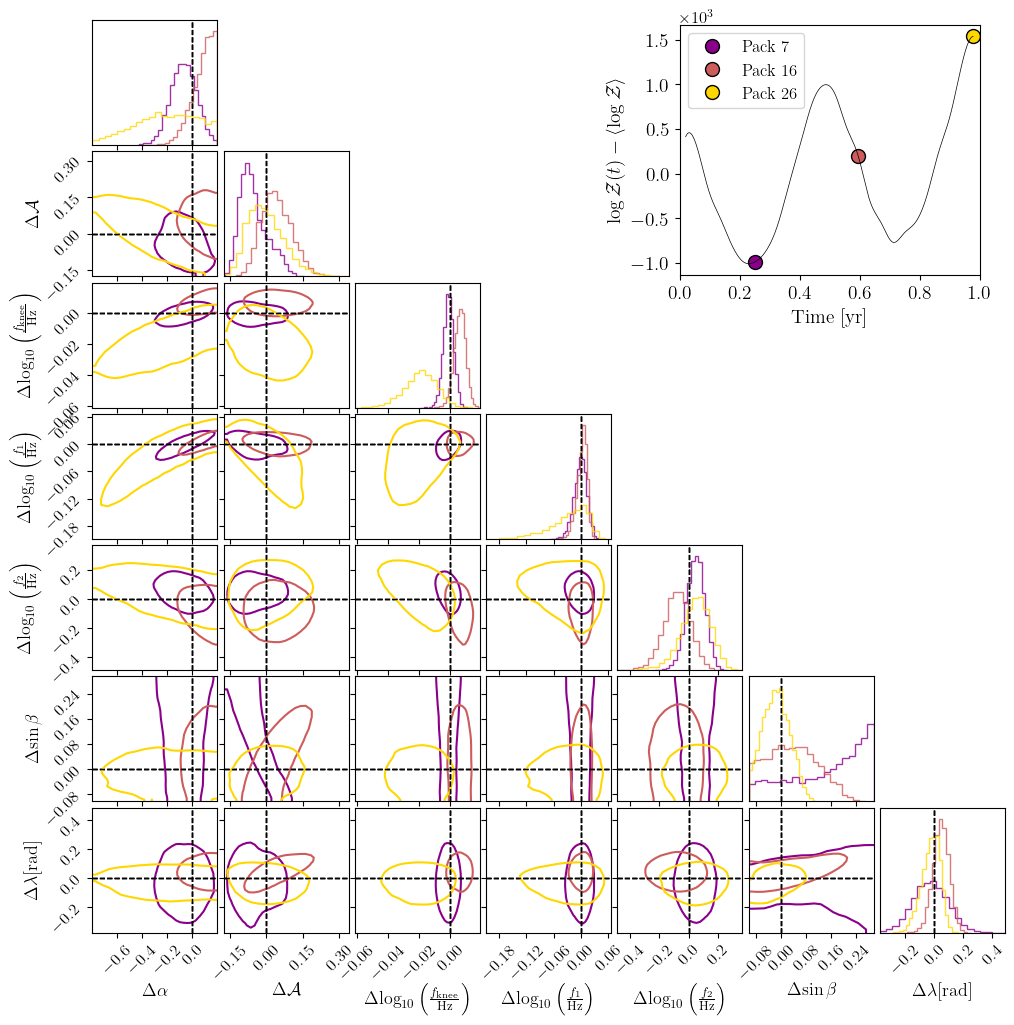

In [12]:
# Plotting logic
fig = plt.figure(figsize=(10, 10))
samples_nested_all = []
packs = [7, 16, 26]

for i, pack_id in enumerate(packs):
    samples, samples_nested, label = load_and_process_samples(pack_id)
    samples_nested_all.append(samples)

    # discard last two parameters
    # Exclude last two parameters
    # label_plot = label_plot[:-2]  # Exclude last two labels

    if packs[i] - 1 == 25:
        colors_tot[packs[i] - 1] = "gold"
    corn(
        samples_nested,  # Exclude last two parameters
        colors_tot[packs[i] - 1],
        fig=fig,
        label=label_plot,
        true=np.zeros(len(label_plot)),
        alpha=0.8,
        line_s="-",
        ht="step",
        linewidth=0.5,
        subplot_bg="w",
    )

# Align xlabels of all subplots vertically
fig.align_xlabels()


# Access all axes and adjust the ticklabel fontsize to 14
axes = fig.get_axes()
for ax in axes:
    ax.tick_params(labelsize=12)

inset_ax = fig.add_axes([0.65, 0.72, 0.3, 0.25])  # Adjust as needed
# Plot zoomed-in 1D histogram of parameter 0 for each pack

inset_ax.plot(
    xnew * (7 * 86400 / year),
    ev_gamma_smooth,
    color="k",
    linewidth=0.5,
    linestyle="-",
    alpha=1.0,
)
# Set exponential notation for y axis tick labels
inset_ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
# Set offset fontsize to 14
inset_ax.yaxis.get_offset_text().set_fontsize(12)

# inset_ax.errorbar(np.arange(1, 52, 2), ev_C, yerr=err_cyclo, fmt='o', color='k',  markersize = 0.5, alpha = 1,)
for i, ind in enumerate(packs):
    inset_ax.scatter(
        np.arange(1, 52, 2)[ind - 1] * (7 * 86400 / year),
        ev_C[ind - 1] - np.mean(ev_C),
        color=colors_tot[packs[i] - 1],
        marker="o",
        s=100,
        edgecolor="k",
        label=f"Pack {ind}",
    )
# ax.scatter(np.linspace(1, 52, 26), ev_gamma, color = 'blue', marker='o')


inset_ax.tick_params(labelsize=14)
inset_ax.set_xlim(0, 1)
inset_ax.set_xlabel("Time [yr]", fontsize=14)
inset_ax.set_ylabel(
    "$\\log \\mathcal{Z}(t) -  \\langle\\log\\mathcal{Z} \\rangle$", fontsize=14
)  # - \left\langle \log \mathcal{Z}\right\rangle$")

# Add legend
colors_legend = [colors_tot[pack_id - 1] for pack_id in packs]
# From named colors to rgba
colors_rgba = [matplotlib.colors.to_rgba(c) for c in colors_legend]

handles = [
    matplotlib.lines.Line2D(
        [0],
        [0],
        marker="o",
        color="none",
        markerfacecolor=colors_rgba[i],
        markeredgecolor="k",
        markersize=10,
        markeredgewidth=1.0,
        linestyle="None",
        label=f"Pack {pack_id}",
    )
    for i, pack_id in enumerate(packs)
]
inset_ax.legend(handles=handles, fontsize=12, loc="upper left")

# Save the plot
fig.savefig(f"../plots/FigureA2.pdf", dpi=300, bbox_inches="tight")
